### Import

In [ ]:
from __future__ import print_function, division
import gzip
import pickle
import gdown
import os
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from IPython.display import display
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Source Data

In [ ]:
#!gdown https://drive.google.com/uc?id=1ojhChs9QryQxG1PYbCDBW3ti5ySDmAze -O data.pkl.gzip

def read_data():
  with gzip.open('./data_19k.pkl.gzip','rb') as f:
    data = pickle.load(f)
  X = join_episodes(data['state'])
  y = join_episodes(data['action'])
  print(y.shape)
  return X,y

def join_episodes(arr,cutoff=50):
	# Stack all  epsiodes in to one array, discard first 50 frames
	stack = np.array(arr[0][cutoff:],dtype=np.float32)
	for i in range(1,len(arr)):
		stack = np.vstack((stack,arr[i][cutoff:]))
	return stack

### Preprocess

In [ ]:
actions = np.array([
	[ 0.0, 0.0, 0.0 ],  # STRAIGHT
	[ 0.0, 1.0, 0.0 ],  # ACCELERATE
	[ 0.0, 0.0, 0.8 ],  # BRAKE
	[ 1.0, 0.0, 0.0 ],  # RIGHT
	[-1.0, 0.0, 0.0 ],  # LEFT
  [ 1.0, 1.0, 0.0 ],  # RIGHT_ACCELERATE
	[-1.0, 1.0, 0.0 ],  # LEFT_ACCELERATE
  [ 1.0, 0.0, 0.8 ],  # RIGHT_BRAKE
	[-1.0, 0.0, 0.8 ]   # LEFT_BRAKE
], dtype=np.float32)

# Replace the colors defined bellow
def replace_color(old_color, new_color, X):
  mask = np.all(X == old_color, axis=3)
  X[mask] = new_color

def preprocess_state(X):

  X_processed = np.array(X)

  new_grass_color = [102., 229., 102.]
  replace_color([102., 229., 102.], new_grass_color, X_processed)
  replace_color([102., 204., 102.], new_grass_color, X_processed)

  new_road_color = [102.0, 102.0, 102.0]
  replace_color([102., 102., 102.], new_road_color, X_processed)
  replace_color([105., 105., 105.], new_road_color, X_processed)
  replace_color([107., 107., 107.], new_road_color, X_processed)

  # Normalize rgb channel
  X_processed = X_processed / 255.0
  # Convert to grayscale
  X_processed = rgb2gray(X_processed)
	# Color whole indicator-bar except the acceleration part black
  X_processed[:,85:,:15] = 0
  X_processed[:,85:,30:] = 0

  return X_processed

def preprocess_actions(y):
    """ Returns actions in id format"""
    #detect_invalid_actions(In_actions) #Need this to make sure no invalid actions present
    ids = []
    for action in y:
        id = np.where(np.all(actions==action, axis=1))
        ids.append(id[0][0])
    return np.array(ids)

def balance_actions(X, y):
    # Find out what action samples are labeled as straight
    is_straight = np.where(y==0)[0]

    # Find out what action samples are labeled as straight
    is_acc = np.where(y==1)[0]

    # Get the index of all other non straight and non advanced turning (direction+accelerate/brake) action samples
    other_actions = np.where(np.logical_and(y>1,y<5))[0]

    # Randomly pick a given amount of straight action
    straight_keep = np.random.choice(is_straight,int(len(is_straight)*0.3))

    # Randomly pick a given amount of acceleration action
    acc_keep = np.random.choice(is_acc,int(len(is_acc)*0.5))

    # Find out what action samples are labeled as brake for multiplication (rare event)
    is_brake = np.where(y==2)[0]

    # Find out what action samples are labeled as right for multiplication (rare event)
    is_right = np.where(y==3)[0]

    # Put all actions that we want to keep together
    final_keep = np.squeeze(np.hstack((other_actions, straight_keep)))
    final_keep = np.squeeze(np.hstack((final_keep, acc_keep)))
    final_keep = np.squeeze(np.hstack((final_keep, is_brake)))
    final_keep = np.squeeze(np.hstack((final_keep, is_right)))
    final_keep = np.sort(final_keep)
    X_bal, y_bal = X[final_keep], y[final_keep]
    # Plot action barcharts
    plot_action_barchart(y, 'Action distribution BEFORE balancing')
    plot_action_barchart(y_bal, 'Action distribution AFTER balancing')
    return X_bal, y_bal

def preprocess_data(X,y):
    print('data size:  ', len(X))
    X = preprocess_state(X)
    y = preprocess_actions(y)
    return balance_actions(X,y) 

def split_data(X,y,ratio=0.2):
    split=int((1-ratio)*len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    return X_train,y_train,X_test,y_test

def plot_action_barchart(actions, title):
    """ Plot the histogram of actions from the expert dataset """
    action_sums = []
    for i in range(9):
      action_sums.append(sum(map(lambda x: x==i, actions)))
    action_id = ["straight","accelerate","brake","right","left","right+acc","left+acc","right+brake","left+brake"]

    x_pos = [i for i, _ in enumerate(action_id)]

    plt.figure(figsize=(15,3))
    plt.bar(x_pos, action_sums, color='blue')
    plt.xlabel("Action IDs")
    plt.ylabel("Sum of action in sample")
    plt.title(title)

    plt.xticks(x_pos, action_id)
    plt.show()

def show_state_as_img(state, mode):
  if (mode=='L'):
    state = state*255
  img = state.astype(np.uint8)
  img = Image.fromarray(img, mode) # L - grayscale RGB - rgb
  display(img)

###Data Pipeline

In [ ]:
def save_trainsplit_data(S,A):
    samples = {
        "state": [],
        "action": []
    }
    samples["state"] = S
    samples["action"] = A
    data_file = os.path.join('./', 'data_train_split.pkl.gzip')
    f = gzip.open(data_file,'wb')
    
    pickle.dump(samples, f)
    f.close()

def save_testsplit_data(S,A):
    samples = {
        "state": [],
        "action": []
    }
    samples["state"] = S
    samples["action"] = A
    data_file = os.path.join('./', 'data_test_split.pkl.gzip')
    f = gzip.open(data_file,'wb')
    pickle.dump(samples, f)
    f.close()

def get_train_data():
    tmp1, tmp2 = read_data()
    S,A = preprocess_data(tmp1, tmp2)
    S_train, A_train, _, _ = split_data(S,A)
    print("train size:  ", len(S_train))
    save_trainsplit_data(S_train, A_train)
    return S_train, A_train

def get_test_data():
    tmp1, tmp2 = read_data()
    S,A = preprocess_data(tmp1, tmp2)
    _,_,S_test, A_test = split_data(S,A)
    print("test size:  ", len(S_test))
    save_testsplit_data(S_test, A_test)
    return S_test, A_test

In [ ]:
class carRacingDataset(Dataset):
    """carRacing dataset."""

    def __init__(self, train, load=False, states=None, actions=None,transform=None):
        if train:
            if load:
                self.states = states
                self.actions = actions
            else:
                self.states, self.actions = get_train_data()
        else:
            if load:
                self.states = states
                self.actions = actions
            else:
                self.states, self.actions = get_test_data()
        self.states = self.states.reshape(self.states.shape[0],1,96,96)
        self.transform = transform

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        state = self.states[idx]
        action = self.actions[idx]
        sample = {'state': state, 'action': action}

        if self.transform:
            sample = self.transform(sample["state"])

        return sample

### Network

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, 4, stride = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride = 3)
        self.fc1 = nn.Linear(64*3*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
def loss_plot(epochs, loss):
    plt.plot(epochs, loss, color='red', label='loss')

def accuracy_plot(epochs, accuracy):
    plt.plot(epochs, accuracy, color='blue', label='accuracy')
    plt.xlabel('epoch')

def train_net(net,dataloader,num_epochs):
    accuracy_vals = []
    loss_vals = []
    for epoch in range(num_epochs):
        correct = 0.0
        epoch_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["state"].to(device), data["action"].to(device)            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #Collect accuracy and loss info
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            epoch_loss += outputs.shape[0] * loss.item()
        # Pring training progress
        print("epoch: ",epoch+1, " loss: ",epoch_loss/len(carRacing_dataset)," accuracy: ", 100*correct/len(carRacing_dataset))
        # Add accuracy and loss info to plot
        accuracy_vals.append(correct/len(carRacing_dataset))
        loss_vals.append(epoch_loss/len(carRacing_dataset))
    
    accuracy_plot(np.linspace(1, num_epochs, num_epochs).astype(int), accuracy_vals)
    loss_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)
    print('Finished Training')

def test_net(net,dataloaderTest):
    correct = 0
    total = 0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for data in dataloaderTest:
            states, actions = data["state"].to(device), data["action"].to(device)
            outputs = net(states)
            _, predicted = torch.max(outputs, dim=1)
            total += actions.size(0)
            correct += (predicted == actions).sum().item()
            y_pred_list.append(predicted.cpu().numpy())
            y_true_list.append(actions.cpu().numpy())
    #print('Accuracy of the network on the test set: %d %%' % (100*correct / total))
    print(classification_report(y_true_list, y_pred_list, digits=3))

# Modeling

## Load data

(19054, 3)
data size:   19054


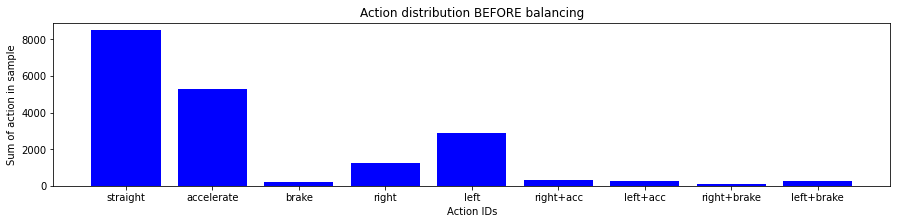

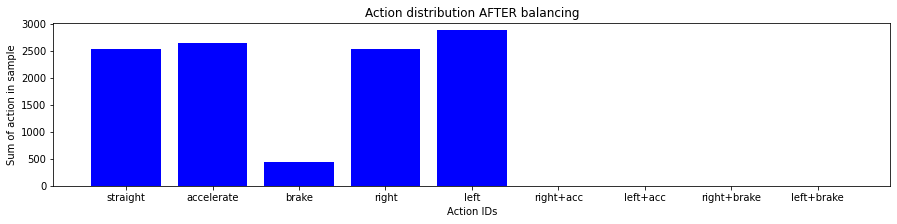

train size:   8838
(19054, 3)
data size:   19054


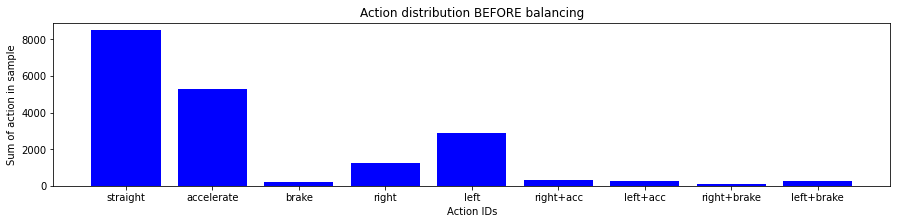

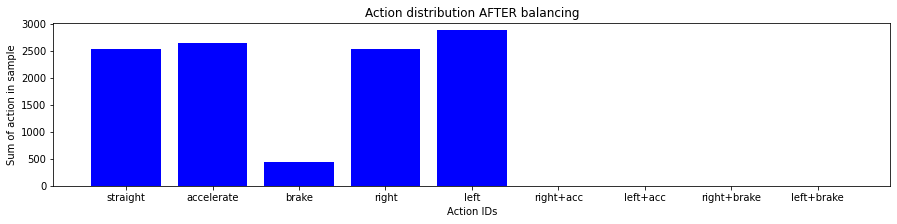

test size:   2210


In [ ]:
# create dataloader for training
carRacing_dataset = carRacingDataset(train = True)
dataloader = DataLoader(carRacing_dataset, batch_size=110,shuffle=True, num_workers=2)
# create dataloader for testing
carRacing_dataset_test = carRacingDataset(train = False)
dataloader_test = DataLoader(carRacing_dataset_test,shuffle=True, num_workers=2)

## Train network

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net.cuda()
train_net(net,dataloader,5000)
model = net

epoch:  1  loss:  1.3586909684584414  accuracy:  41.14203058272489
epoch:  2  loss:  1.2465077403130684  accuracy:  45.61234329797493
epoch:  3  loss:  1.1702622357832366  accuracy:  47.713183634109384
epoch:  4  loss:  0.9435495349769341  accuracy:  54.621848739495796
epoch:  5  loss:  0.877048769237286  accuracy:  57.25306516049042
epoch:  6  loss:  0.861417746548811  accuracy:  57.50103320016531
epoch:  7  loss:  0.8514818709437587  accuracy:  58.024521283923406
epoch:  8  loss:  0.8432077796092324  accuracy:  58.16916930706709
epoch:  9  loss:  0.8389280049625811  accuracy:  58.39647334343574
epoch:  10  loss:  0.8328808201691191  accuracy:  58.52045736327318
epoch:  11  loss:  0.8284293021819433  accuracy:  58.671993387518945
epoch:  12  loss:  0.8257928790427351  accuracy:  59.00261744041879
epoch:  13  loss:  0.8209235252206164  accuracy:  58.97506543601047
epoch:  14  loss:  0.8162739829906075  accuracy:  59.147265463562476
epoch:  15  loss:  0.8143805688710757  accuracy:  59.2

## Test Model

In [ ]:
test_net(model,dataloader_test)

              precision    recall  f1-score   support

           0      0.405     0.286     0.336       576
           1      0.358     0.521     0.424       436
           2      0.593     0.160     0.252       100
           3      0.838     0.581     0.686       516
           4      0.608     0.820     0.698       582

    accuracy                          0.536      2210
   macro avg      0.560     0.474     0.479      2210
weighted avg      0.559     0.536     0.527      2210



## Save Model

In [ ]:
PATH = './5000epoch_base.pth'
torch.save(model.state_dict(), PATH)

## Preload model and test data

In [ ]:
with gzip.open('./data_test_split.pkl.gzip','rb') as f:
    data = pickle.load(f)
    S_test = data['state']
    A_test = data['action']
f.close()
carRacing_dataset_test = carRacingDataset(train = False, load = True, states = S_test, actions = A_test)#, transform=transform)
dataloader_test = DataLoader(carRacing_dataset_test,shuffle=False, num_workers=2)

In [ ]:
pretrained_model = './car_racing_largenet_5000.pth'
model = Net()
model.load_state_dict(torch.load(pretrained_model))
model.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

# Pruning

## Functions

In [ ]:
def global_fc_unstructured_prune(net,ratio):
    model.cuda()
    parameters_to_prune = (
        (net.fc1, 'weight'),
        (net.fc2, 'weight'),
        (net.fc3, 'weight')
    )
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=ratio)

def global_conv_unstructured_prune(net,ratio):
    model.cuda()
    parameters_to_prune = (
      (net.conv1, 'weight'),
      (net.conv2, 'weight'),
      (net.conv3, 'weight')
    )
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=ratio)

def layerwise_conv_unstructured_prune(net,ratio):
    model.cuda()
    prune.l1_unstructured(net.conv1, name='weight', amount=ratio)
    prune.l1_unstructured(net.conv2, name='weight', amount=ratio)
    prune.l1_unstructured(net.conv3, name='weight', amount=ratio)

def layerwise_conv_structured_prune(net,ratio):
    model.cuda()
    prune.ln_structured(net.conv1, name='weight', amount=ratio, n=1, dim=0)
    prune.ln_structured(net.conv2, name='weight', amount=ratio, n=1, dim=0)
    prune.ln_structured(net.conv3, name='weight', amount=ratio, n=1, dim=0)

def remove_prune_params(model):
    prune.remove(model.conv1,"weight")
    prune.remove(model.conv2,"weight")
    prune.remove(model.conv3,"weight")
    prune.remove(model.fc1,"weight")
    prune.remove(model.fc2,"weight")
    prune.remove(model.fc3,"weight")

def print_prune_results(net):
    print(
        "Sparsity in conv1.weight: {:.2f}%".format(
            100. * float(torch.sum(net.conv1.weight == 0))
            / float(net.conv1.weight.nelement())
        )
    )
    print(
        "Sparsity in conv2.weight: {:.2f}%".format(
            100. * float(torch.sum(net.conv2.weight == 0))
            / float(net.conv2.weight.nelement())
        )
    )
    print(
        "Sparsity in conv3.weight: {:.2f}%".format(
            100. * float(torch.sum(net.conv3.weight == 0))
            / float(net.conv3.weight.nelement())
        )
    )
    print(
        "Sparsity in fc1.weight: {:.2f}%".format(
            100. * float(torch.sum(net.fc1.weight == 0))
            / float(net.fc1.weight.nelement())
        )
    )
    print(
        "Sparsity in fc2.weight: {:.2f}%".format(
            100. * float(torch.sum(net.fc2.weight == 0))
            / float(net.fc2.weight.nelement())
        )
    )
    print(
        "Sparsity in fc3.weight: {:.2f}%".format(
            100. * float(torch.sum(net.fc3.weight == 0))
            / float(net.fc3.weight.nelement())
        )
    )
    num_pruned = float(torch.sum(net.conv1.weight == 0)
                + torch.sum(net.conv2.weight == 0)
                + torch.sum(net.conv3.weight == 0)
                + torch.sum(net.fc1.weight == 0)
                + torch.sum(net.fc2.weight == 0)
                + torch.sum(net.fc3.weight == 0)
            )
    num_total = float(
                net.conv1.weight.nelement()
                + net.conv2.weight.nelement()
                + net.conv3.weight.nelement()
                + net.fc1.weight.nelement()
                + net.fc2.weight.nelement()
                + net.fc3.weight.nelement()
            )
    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(num_pruned)/float(num_total)

        )
    )
    print("Total number of weights: ",num_total)
    print("Number of unpruned weights: ",num_total-num_pruned)

## Prune model

In [ ]:
pretrained_model = './car_racing_largenet_5000.pth'
model = Net()
model.load_state_dict(torch.load(pretrained_model))
#global_conv_unstructured_prune(model,0.8)
layerwise_conv_unstructured_prune(model,0.0)
#layerwise_conv_structured_prune(model,0.8)
global_fc_unstructured_prune(model,0.0)
# Remove pruning temp params
remove_prune_params(model)
print_prune_results(model)
#count_sign_diff(model)

Sparsity in conv1.weight: 0.00%
Sparsity in conv2.weight: 0.00%
Sparsity in conv3.weight: 0.00%
Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Global sparsity: 0.00%
Total number of weights:  207888.0
Number of unpruned weights:  207888.0


## Save model

In [ ]:
PATH = './car_racing_largenet_p80_layerwise_unstructured_finetuned.pth'
torch.save(model.state_dict(), PATH)

## Fine-tune model

epoch:  1  loss:  21.7916922588698  accuracy:  33.457795881421134
epoch:  2  loss:  6.318904612878513  accuracy:  41.69495360941389
epoch:  3  loss:  4.3264882637920845  accuracy:  44.534962661235575
epoch:  4  loss:  3.284208327457629  accuracy:  48.71011541072641
epoch:  5  loss:  2.640258769585445  accuracy:  51.538809685449195
epoch:  6  loss:  2.199879774197002  accuracy:  54.29961529757864
epoch:  7  loss:  1.9202890122576142  accuracy:  57.06042090970808
epoch:  8  loss:  1.7186625945025857  accuracy:  57.92034396922381
epoch:  9  loss:  1.5429922574568344  accuracy:  59.651504865354156
epoch:  10  loss:  1.4297382005282349  accuracy:  60.51142792486988
epoch:  11  loss:  1.3453959791766597  accuracy:  61.09979633401222
epoch:  12  loss:  1.2655168951272586  accuracy:  62.08418194161575
epoch:  13  loss:  1.2142590999495366  accuracy:  63.05725277212039
epoch:  14  loss:  1.1753860103865506  accuracy:  62.9214754469337
epoch:  15  loss:  1.1304173368786115  accuracy:  63.7474541

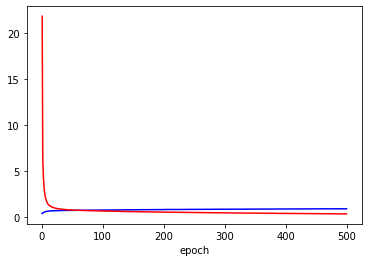

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_net(model,dataloader,500)

## Test Model

In [ ]:
model.cuda()
test_net(model,dataloader_test)

              precision    recall  f1-score   support

           0      0.429     0.382     0.404       545
           1      0.407     0.581     0.479       425
           2      0.732     0.300     0.426       100
           3      0.857     0.613     0.714       537
           4      0.700     0.804     0.748       603

    accuracy                          0.588      2210
   macro avg      0.625     0.536     0.554      2210
weighted avg      0.616     0.588     0.589      2210

